# Measuring Engagement and Satisfaction in Online Mental Health Platform Conversations

## Data preprocessing

In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
pd.options.display.max_colwidth = 500

In [370]:
df = pd.read_csv("mentalhealthsupport_dyadic_convs_clean_emotion.csv")

In [371]:
df.head(0)

,conversation id,subreddit,post title,author,dialog turn,text,compound,sentiment,emotion prediction


In [372]:
df = df.rename(columns={'conversation id': 'conversation_id', 'post title': 'post_title', 'dialog turn': 'dialog_turn', 'emotion prediction': 'emotion_prediction'})
df.head()

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
0,1,MentalHealthSupport,"DBT cheat sheet, for when you need a quick reminder",missfittnc,1,[DBT Skils over view](http://www.dbtselfhelp.com/html/dbt_skills_list.html),0.0000,neutral,anticipating
1,1,MentalHealthSupport,"DBT cheat sheet, for when you need a quick reminder",skbloom,2,Thanks for sharing!,0.7177,positive,grateful
2,2,MentalHealthSupport,[BPD] Difficulty in avoiding drama,I_Am_Jacks_BPD,1,"*** **All names have been changed to protect the guilty** *** It's been two days since my meltdown subsided. I spent the better part of yesterday feeling numb, which is par for the course. I'm doing even better today. I spent the first half hour of waking up laying on the couch reading my news feed and browsing Reddit instead of sleeping for 2-3 hours. Anyway, as I sit here listening to music and sifting through the events of the past three weeks, I've come to the realization that my need ...",0.9654,positive,anticipating
3,2,MentalHealthSupport,[BPD] Difficulty in avoiding drama,redsaidfred,2,"The best advice someone ever told me was... ""I am NOT in control. I CANNOT change someone else's behaviour. Just let it go, and the universe will unfold as it should."" Felt like the weight of the world was lifted. I need to remind myself constantly...",0.7717,positive,faithful
4,3,MentalHealthSupport,How are you today and what's your recovery progress?,professorplumdidit,1,I thought maybe we should just do a thread to support each other in our own individual recovery goals as well as generally how people are feeling.,0.6486,positive,hopeful


In [373]:
### --- CLEANING OUT MONOLOGUES FROM DATASET --- ###

# Group data by conversation id and calculate count of each conversation id
df_conv = df.groupby("conversation_id").count()
df_conv = df_conv.drop(columns=["subreddit", "post_title", "author", "text", "compound", "sentiment", "emotion_prediction"])
print("Number of conversations in subreddit: ", len(df_conv))

# Separate conversation id's with a single occurrence as monologues
df_mono = df_conv[df_conv["dialog_turn"] == 1]
print("Number of monologues in subreddit: ", len(df_mono))
df_mono_ids = df_mono.reset_index()
df_mono_ids = df_mono_ids["conversation_id"]

# Separate conversation id's with multiple occurrences as dialogues
df_dia = df_conv[df_conv["dialog_turn"] > 1]
print("Number of dialogues in subreddit: ", len(df_dia))
df_dia = df_dia.reset_index()
df_dia = df_dia.drop(columns=['dialog_turn'])

# Join dialogue conversation id's with original data such that only dialogues remain in the dataset
df = df.join(df_dia.set_index('conversation_id'), on='conversation_id', how="right") 

### ---------------------------------------------- ###

Number of conversations in subreddit:  3551
Number of monologues in subreddit:  29
Number of dialogues in subreddit:  3522


In [374]:
conversation = df[df["conversation_id"] == 1003]
conversation

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
2418,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,1,"A bit of background information. I smoked weed twice in my life, first time in november of 2018 and second in april of 2019. both times i had extreme panic attacks that were amplified by my depersonalization disorder. I get really stressed out when I think about those episodes I had, and worry about death constantly. Recently, my girlfriend has admitted to me that she’s been smoking weed regularly for over a year. I don’t know why, but that bothered me and put me in a really depressed moo...",-0.9820,negative,grateful
2419,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,2,"Well, I'm going to take a stab at it and say that you have mixed feelings and anxiety because you've been raised to think of weed as a bad thing and it's been demonized. So there's already a stigma there for you when it comes to the drug. Then there's the other side of it, which is you tried it, you had a severe panic attack (which can happen depending on the type of weed. I've had one as well with some kinds, and not with others. And I've had depersonalization on weed too. Your frame of min...",-0.8813,negative,anxious
2420,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,3,"you hit the nail on the head with that egg analogy. except if i were you, i’d be under this false idea that eggs are killing everyone and turning them into shitty burnouts. i don’t know why.",-0.8402,negative,sentimental
2421,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,4,Awww. I’m sorry you feel that way. I’d look into why you’re having that reaction to it. 💗,0.6808,positive,sentimental
2422,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,5,i feel so alone in my life and it eats me up inside to hear that the one i love is having a normal reaction to it. i feel left out and angry at the same time and i just cut my wrists tonight to get my mind off of her. i’m a fucking wreck,-0.7192,negative,embarrassed
2423,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,6,Did you self-harm or attempt suicide? Are you okay?!,-0.6430,negative,sentimental
2424,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,7,self harm.,-0.5423,negative,surprised
2425,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,8,How are you doing today?,0.0000,neutral,grateful
2426,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,9,"i’ve been mych, much better since i last logged into reddit. thanks for sticking around, and for your help. seriously.",0.7783,positive,grateful
2427,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,10,So glad to hear that! And you’re very welcome. :),0.8795,positive,anticipating


## Measuring the level of engagement

### Does the speaker respond back when the listener gives a response?

In [375]:
def extract_responses(conversation):
    speaker = conversation.author.iloc[0]
    listener = conversation[conversation["author"] != speaker]["author"].unique().item()
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses)
    num_listener_responses = len(listener_responses)
    
    return speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses

In [376]:
def calculate_speaker_listener_ratio(conversation):
    _, _, _, _, num_speaker_responses, num_listener_responses = extract_responses(conversation)
    speaker_listener_ratio = num_speaker_responses / num_listener_responses
    
    engagement = ""
    if len(conversation) == 2:
        engagement = "low"
    elif len(conversation) <= 4 and speaker_listener_ratio < 1:
        engagement = "low"
    elif len(conversation) <= 4 and speaker_listener_ratio >= 1:
        engagement = "moderate"
    elif len(conversation) >= 4 and speaker_listener_ratio < 1:
        engagement = "moderate"
    elif len(conversation) >= 4  and speaker_listener_ratio >= 1:
        engagement = "high"
        
    return speaker_listener_ratio, engagement

In [377]:
calculate_speaker_listener_ratio(conversation)

(1.0, 'high')

### Does the listener ask any informative questions or give any suggestions? 

In [378]:
speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conversation)

In [379]:
df[df["emotion_prediction"]=="questioning"]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
799,342,MentalHealthSupport,Mental Health in the Black Community,yadadameannn,4,thanks man. We just got everything fixed. We were working on coding this weekend. Everything is fine now.,0.5719,positive,questioning
1070,455,MentalHealthSupport,I’m really struggling,McThrowaway42069,2,"Dont. No matter how bad it seems there a people who care for you. You are loved, don't hurt the people who care about you.",0.8635,positive,questioning
1361,578,MentalHealthSupport,Let Me Introduce Myself,antwerpbanana,2,"Hi Caty, thank you for sharing your story. I hope we can be of help to you here.",0.8720,positive,questioning
4239,1761,MentalHealthSupport,Feel awful,TheBassClarinetBoy,2,"Hey friend. I’m recommend talking with people you trust about this, and trying to find professional help",0.8934,positive,questioning
5636,2414,MentalHealthSupport,Need help! Mental health destroying relationship...,Rock-it1,2,Therapist here. Can you provide a few more details?,0.0000,neutral,questioning


In [380]:
print(df[(df["conversation_id"]==342) & (df["dialog_turn"]==4)]["text"])
print(df[(df["conversation_id"]==455) & (df["dialog_turn"]==2)]["text"])
print(df[(df["conversation_id"]==578) & (df["dialog_turn"]==2)]["text"])
print(df[(df["conversation_id"]==1761) & (df["dialog_turn"]==2)]["text"])
print(df[(df["conversation_id"]==2414) & (df["dialog_turn"]==2)]["text"])

799    thanks man. We just got everything fixed. We were working on coding this weekend. Everything is fine now. 
Name: text, dtype: object
1070    Dont. No matter how bad it seems there a people who care for you. You are loved, don't hurt the people who care about you.
Name: text, dtype: object
1361    Hi Caty, thank you for sharing your story. I hope we can be of help to you here.
Name: text, dtype: object
4239    Hey friend. I’m recommend talking with people you trust about this, and trying to find professional help
Name: text, dtype: object
5636    Therapist here. Can you provide a few more details?
Name: text, dtype: object


The emotion prediction tags are not very accurate. Only the last of the listener responses above are questioning. 

In [381]:
df[df["emotion_prediction"]=="suggesting"]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction


There are no posts with a suggesting tag in this subreddit. Therefore, it cannot be utilized in the calculation of the engagement measure.

### How the literature measures engagement

## Measuring the level of satisfaction

### Lexical details: "Thank you", "It means a lot"

### Shift of sentiment in speaker responses (sentiment trend)

In [382]:
speaker_responses

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
2418,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,1,"A bit of background information. I smoked weed twice in my life, first time in november of 2018 and second in april of 2019. both times i had extreme panic attacks that were amplified by my depersonalization disorder. I get really stressed out when I think about those episodes I had, and worry about death constantly. Recently, my girlfriend has admitted to me that she’s been smoking weed regularly for over a year. I don’t know why, but that bothered me and put me in a really depressed moo...",-0.9820,negative,grateful
2420,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,3,"you hit the nail on the head with that egg analogy. except if i were you, i’d be under this false idea that eggs are killing everyone and turning them into shitty burnouts. i don’t know why.",-0.8402,negative,sentimental
2422,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,5,i feel so alone in my life and it eats me up inside to hear that the one i love is having a normal reaction to it. i feel left out and angry at the same time and i just cut my wrists tonight to get my mind off of her. i’m a fucking wreck,-0.7192,negative,embarrassed
2424,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,7,self harm.,-0.5423,negative,surprised
2426,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,9,"i’ve been mych, much better since i last logged into reddit. thanks for sticking around, and for your help. seriously.",0.7783,positive,grateful


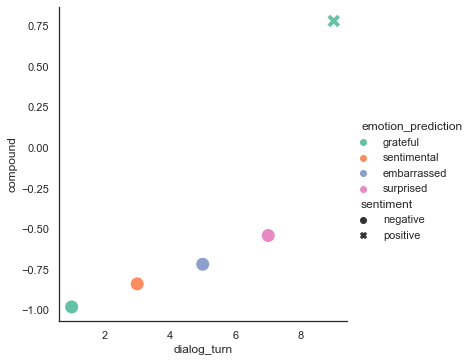

In [383]:
sns.set_theme(style="white")
sns.relplot(x="dialog_turn", y="compound", hue="emotion_prediction", style="sentiment", palette="Set2", data=speaker_responses, s=200)

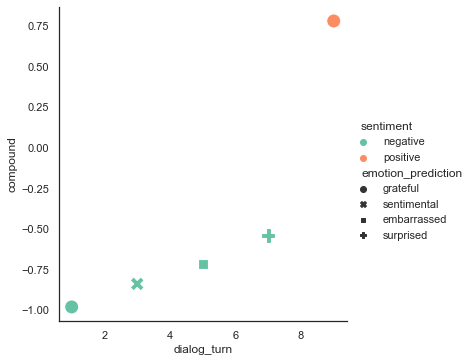

In [384]:
sns.set_theme(style="white")
sns.relplot(x="dialog_turn", y="compound", hue="sentiment", style="emotion_prediction", palette="Set2",data=speaker_responses, s=200)

In [385]:
def calculate_sentiment_shift(responses):
    x = np.array(responses["dialog_turn"]).reshape((-1, 1))
    y = np.array(responses["compound"])
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    
    satisfaction = ""
    if r_sq >= 0.7:
        satisfaction = "positive"
    elif r_sq >= 0.3:
        satisfaction = "moderate"
    elif r_sq < 0.3 and r_sq >= 0:
        satisfaction = "neutral"
    elif r_sq < 0:
        satisfaction = "negative"
        
    return r_sq, satisfaction

In [386]:
calculate_sentiment_shift(speaker_responses)

(0.7202688260981651, 'positive')

In [387]:
def get_sentiment(responses):
    sentiments = responses["sentiment"]
    final_sentiment = sentiments.iloc[-1]
    
    return sentiments, final_sentiment

### If the last speaker turn has grateful emotion and has positive sentiment

In [390]:
def get_emotion_prediction(responses):
    emotions = responses["emotion_prediction"]
    final_emotion = emotions.iloc[-1]
    
    return emotions, final_emotion

In [391]:
get_emotion_prediction(speaker_responses)

(2418       grateful
 2420    sentimental
 2422    embarrassed
 2424      surprised
 2426       grateful
 Name: emotion_prediction, dtype: object,
 'grateful')

### How the literature measures satisfaction

## Equation to measure the engagement and satisfaction of a conversation

In [395]:
def classify_conversation(conversation):
    print(calculate_speaker_listener_ratio(conversation)[1] + " engagement, " + calculate_sentiment_shift(speaker_responses)[1] + " satisfaction")

In [396]:
classify_conversation(conversation)

high engagement, positive satisfaction
